In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import pickle

In [2]:
data_location = "sqlite:///../../../data/data.db"

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
ohlc = pd.read_sql("""
SELECT  
* 
FROM
ohlc
""", data_location)
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [5]:
ohlc.shape

(11627, 9)

In [6]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


In [7]:
tokens = ohlc.token.unique()
tokens

array(['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'DOT', 'AVAX', 'ATOM', 'CRV',
       'AAVE', 'COMP'], dtype=object)

In [8]:
def df_merge(left, right):
    return pd.merge(left, right, on="ts", how="inner")

In [9]:
X = reduce(df_merge, [
           (lambda df: df.assign(vol=vol_ohlc(df).fillna(0),
                                ret=df.close.pct_change()
                               )[["ts","vol","ret"]].rename(
                               columns={col: f"{col}_{token}" for col in ["vol", "ret"]}
                               )
           )(ohlc[ohlc.token == token])
           for token in tokens]
          ).set_index("ts")

X.head()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2021-11-01 01:00:00,0.0,0.004357,0.0,0.006874,0.0,0.0000,0.0,0.027359,0.0,0.003203,...,0.0,-0.006346,0.0,0.008193,0.0,0.000725,0.0,0.008043,0.0,-0.002281
2021-11-01 02:00:00,0.0,-0.004508,0.0,-0.005322,0.0,-0.0002,0.0,-0.009879,0.0,-0.008667,...,0.0,-0.006231,0.0,-0.025419,0.0,-0.031791,0.0,-0.009171,0.0,-0.006020
2021-11-01 03:00:00,0.0,-0.012132,0.0,-0.013126,0.0,0.0001,0.0,-0.021692,0.0,-0.007618,...,0.0,-0.005329,0.0,-0.013943,0.0,-0.010431,0.0,-0.013301,0.0,-0.022273
2021-11-01 04:00:00,0.0,-0.010186,0.0,-0.010679,0.0,0.0000,0.0,-0.003039,0.0,-0.006903,...,0.0,-0.008667,0.0,-0.020046,0.0,0.004514,0.0,-0.016452,0.0,-0.024002


In [10]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [11]:
X.shape

(1056, 22)

In [12]:
y.shape

(1056,)

In [13]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [14]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

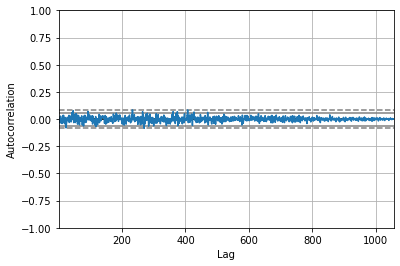

In [15]:
autocorrelation_plot(y)

In [16]:
X.corrwith(y)

vol_BTC     0.028694
ret_BTC    -0.013849
vol_ETH     0.023572
ret_ETH     0.030649
vol_USDT    0.006850
ret_USDT   -0.044401
vol_SOL     0.034853
ret_SOL    -0.029855
vol_ADA     0.038880
ret_ADA     0.000249
vol_DOT     0.059041
ret_DOT     0.008194
vol_AVAX    0.041409
ret_AVAX    0.016919
vol_ATOM   -0.002235
ret_ATOM    0.055462
vol_CRV     0.019829
ret_CRV    -0.005844
vol_AAVE    0.036051
ret_AAVE    0.019896
vol_COMP    0.059843
ret_COMP    0.020113
dtype: float64

In [17]:
pd.isnull(X).sum()

vol_BTC     0
ret_BTC     1
vol_ETH     0
ret_ETH     1
vol_USDT    0
ret_USDT    1
vol_SOL     0
ret_SOL     1
vol_ADA     0
ret_ADA     1
vol_DOT     0
ret_DOT     1
vol_AVAX    0
ret_AVAX    1
vol_ATOM    0
ret_ATOM    1
vol_CRV     0
ret_CRV     1
vol_AAVE    0
ret_AAVE    1
vol_COMP    0
ret_COMP    1
dtype: int64

In [18]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_validate, \
GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer

In [19]:
SEED = 0

In [20]:
benchmark = -0.008575141851714435

In [21]:
class AddShp(BaseEstimator, TransformerMixin):
    def __init__(self, tokens):
        self.tokens = tokens
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for token in self.tokens:
            X_[f"shp_{token}"] = X_[f"ret_{token}"] / X_[f"vol_{token}"]
            X_.loc[X[f"vol_{token}"]==0, f"shp_{token}"] = 0.0
        return X_

In [22]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)["test_score"])

In [23]:
test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [24]:
pipeline = Pipeline([
    ("addshp", AddShp(tokens)),
    ("impute", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0.0)),
    ("scale", MaxAbsScaler()),
    ("pca", PCA()),
    ("model", AdaBoostRegressor(Ridge(), random_state=SEED))
])

param_grid = {
    "pca__n_components": [1, 5, 10, 20, 33],
    "model__n_estimators": [25, 50, 75],
    "model__base_estimator__alpha": [0.1, 0.5, 1.0],
}

pipeline_cv = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scorer, n_jobs=-1)
pipeline_cv.fit(X, y)
best_model = pipeline_cv.best_estimator_
best_params = pipeline_cv.best_params_
print(best_params)

rmse = evaluate_model(best_model, X, y)
print(rmse)
if rmse > benchmark:
    print(f"Improvement: {rmse-benchmark} ({round((rmse-benchmark)/np.abs(benchmark)*100, 4)}%)")

{'model__base_estimator__alpha': 0.5, 'model__n_estimators': 50, 'pca__n_components': 5}
-0.008548584413562035
Improvement: 2.6557438152399748e-05 (0.3097%)


We can see that through hard voting, the VotingRegressor estimator performs better than any of its component. Therefore, we will use it as the base model to perform hyperparameter tuning.

Let's check the learning curve of our best model

In [25]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\envs\\HW8\\lib\\site-packages\\matplotlib\\pyplot.py'>

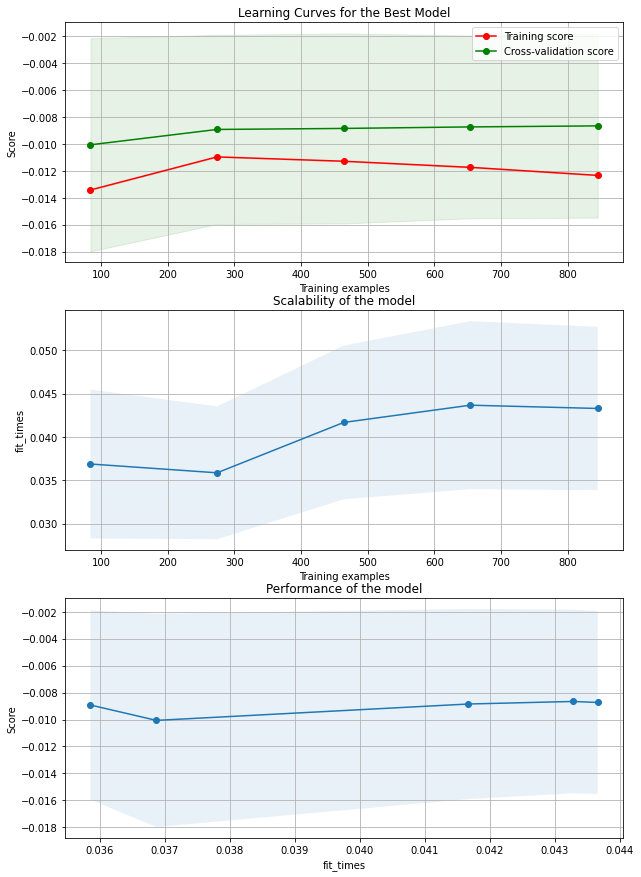

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves for the Best Model"

plot_learning_curve(best_model, title, X, y, axes=axes, cv=cv, scoring=scorer, n_jobs=-1)

In [27]:
pickle.dump(best_model, open("best_model.pkl", "wb"))